# Sales Forecasting With Time Series

Here we have 9 stores in normal and seasonal times are selling products that I will focus on their performance through these times of the year and predicting more about thier performance. 

* Store: the store code. We have 9 stores in total (1-10), 9 is missed.
* Product: the product code. We have 3 products in total (1,2,3).
* Is_Holiday: an indicator for whether that week contains holiday: 0 = no, 1 = yes.
* Base Price: base or everyday price without a discount.
* Price: Actual price for each week. They are either promotion prices when promotion is going on or everyday prices otherwise.
* Weekly_Units_Sold: Weekly units sold.

In [93]:
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
from fbprophet import Prophet
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from math import sqrt
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
#from ggplot import *
%matplotlib inline


In [94]:
data = pd.read_csv('Sales_Product.csv')
data.sample(5)

,Store,Product,Date,Is_Holiday,Base Price,Price,Weekly_Units_Sold
775,2,3,4/1/2011,False,21.99,21.99,62
403,1,3,5/4/2012,False,19.99,19.99,71
3231,8,2,9/23/2011,False,5.99,5.99,229
3453,10,1,7/2/2010,False,9.99,9.99,181
1514,4,2,9/16/2011,False,5.99,5.99,646


In [95]:
type('Date') #convert Date column to date 

str

In [96]:
data['Date'] = pd.to_datetime(data.Date)
#make a Date column an index to the dataset
data.set_index('Date', inplace= True)
#let's do some changes on the dataset to help us asset weekly, monthly and even yearly since we have 3 years analysis.
data['Year'] = data.index.year
data['Month'] = data.index.month
data['week'] = data.index.week
data['Day'] = data.index.day
data.head()

,Store,Product,Is_Holiday,Base Price,Price,Weekly_Units_Sold,Year,Month,week,Day
Date,,,,,,,,,,
2010-02-05,1,1,False,9.99,7.99,245,2010,2,5,5
2010-02-12,1,1,True,9.99,7.99,453,2010,2,6,12
2010-02-19,1,1,False,9.99,7.99,409,2010,2,7,19
2010-02-26,1,1,False,9.99,7.99,191,2010,2,8,26
2010-03-05,1,1,False,9.99,9.99,145,2010,3,9,5


In [97]:
data.isnull().sum() #no null data found, great!

Store                0
Product              0
Is_Holiday           0
Base Price           0
Price                0
Weekly_Units_Sold    0
Year                 0
Month                0
week                 0
Day                  0
dtype: int64

In [98]:
#add new column of weekly sales actual price
data['Weekly_Sales_Price'] = data['Price'] * data['Weekly_Units_Sold']
data.sample(7)

,Store,Product,Is_Holiday,Base Price,Price,Weekly_Units_Sold,Year,Month,week,Day,Weekly_Sales_Price
Date,,,,,,,,,,,
2012-05-25,6,1,False,10.99,8.79,168,2012,5,21,25,1476.72
2011-02-11,5,3,True,21.99,21.99,21,2011,2,6,11,461.79
2012-03-09,4,1,False,10.99,10.99,183,2012,3,10,9,2011.17
2012-01-20,6,3,False,19.99,19.99,89,2012,1,3,20,1779.11
2011-11-11,3,2,False,5.99,5.99,107,2011,11,45,11,640.93
2012-05-11,7,1,False,10.99,8.79,55,2012,5,19,11,483.45
2011-08-12,3,2,False,5.99,5.99,105,2011,8,32,12,628.95


In [99]:
data.Weekly_Units_Sold.describe()

count    3861.000000
mean      215.952603
std       236.273397
min        13.000000
25%        69.000000
50%       130.000000
75%       278.000000
max      2557.000000
Name: Weekly_Units_Sold, dtype: float64

In [100]:
data.groupby('Store')['Weekly_Sales_Price'].sum().sort_values()

Store
5      252647.96
3      287826.40
7      409744.36
8      580048.35
1      767658.68
6      886616.48
2     1059392.94
4     1320660.26
10    1756071.71
Name: Weekly_Sales_Price, dtype: float64

In [101]:
data.groupby('Store')['Weekly_Units_Sold'].sum().sort_values()

Store
5      27300
3      31689
7      44027
8      65273
1      86699
6      97698
2     121465
4     158718
10    200924
Name: Weekly_Units_Sold, dtype: int64

Store 5 has the lowset sales rate among all store, on the contrary store 10 has the highest sales rate weekly.
Is that happening on a sort of time pattern? Does sales gets higher in holidays?

### Stores Analysis

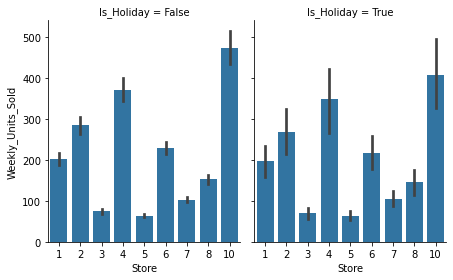

In [102]:
st = sns.FacetGrid(data, col="Is_Holiday", height=4, aspect=.8)
st.map(sns.barplot, "Store", "Weekly_Units_Sold")

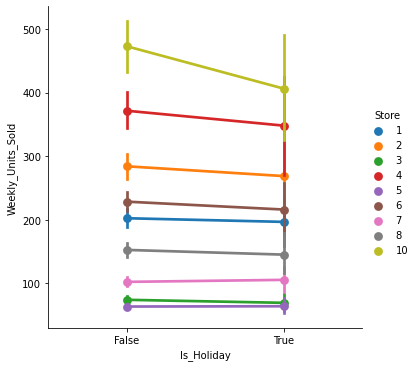

In [103]:
#How holidays affect the selling performance for stores?
sns.factorplot(data= data, x= 'Is_Holiday', y= 'Weekly_Units_Sold', hue= 'Store');

In [104]:
D1=data[data['Is_Holiday'] == True].query('Store == 10').sum()['Weekly_Units_Sold']
D2=data[data['Is_Holiday'] == False].query('Store == 10').sum()['Weekly_Units_Sold']
D2-D1


176542.0

176542 sold units is the difference between Holidays performance and usual ones "taking in consideration there are 30 holidays only" over the whole period for only store 10

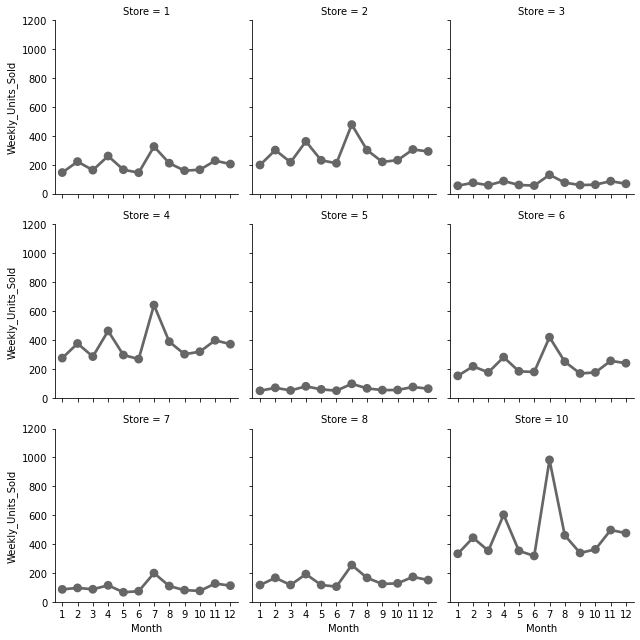

In [105]:
st= sns.FacetGrid(data, col='Store',col_wrap=3, ylim=(0, 1200))
st.map(sns.pointplot, "Month", "Weekly_Units_Sold", color=".4", ci=None)

From Stores analysis above, most Stores affected badly on holidays especially store 10 which as such a big decrease in weekly sold units. But there are months making a huge impact on sales and also especially store 10 which has a jump in sales through July and April.

### Products Analysis

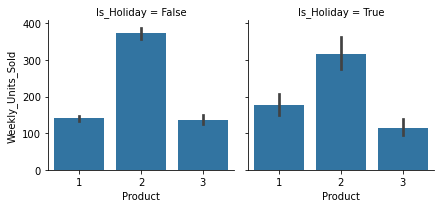

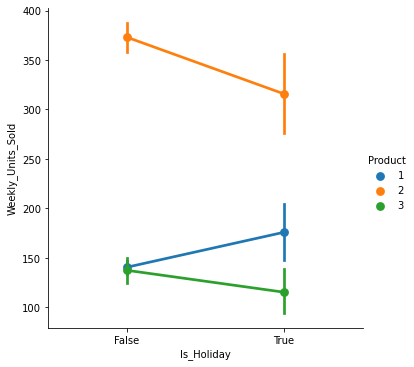

In [106]:
prd = sns.FacetGrid(data, col="Is_Holiday",col_wrap=3, height=3, aspect=1)
prd.map(sns.barplot,"Product","Weekly_Units_Sold");
sns.factorplot(data= data, x= 'Is_Holiday', y= 'Weekly_Units_Sold', hue= 'Product');

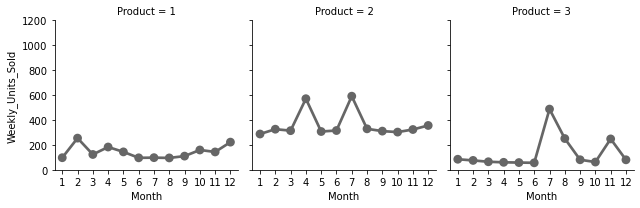

In [107]:
prd= sns.FacetGrid(data, col='Product',col_wrap=3, ylim=(0, 1200))
prd.map(sns.pointplot, "Month", "Weekly_Units_Sold", color=".4", ci=None);

From products analysis above, most sold product is number 2 and affected badly in holidays, on the contrary product 1 which holidays have a better effect on its selling performance. product 3 has a great performance in July like it's a seasonal product.

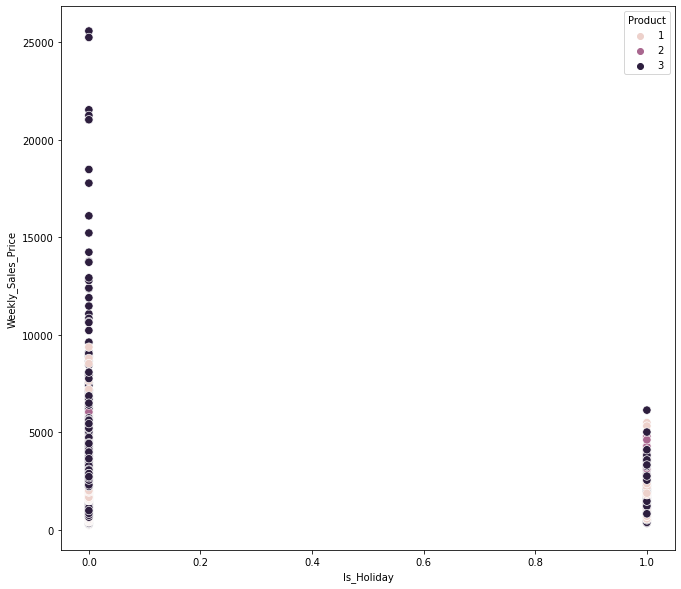

In [108]:
plt.figure(figsize = (11,10))
sns.scatterplot(data= data, x= 'Is_Holiday', y= 'Weekly_Sales_Price', hue= 'Product',s=70);

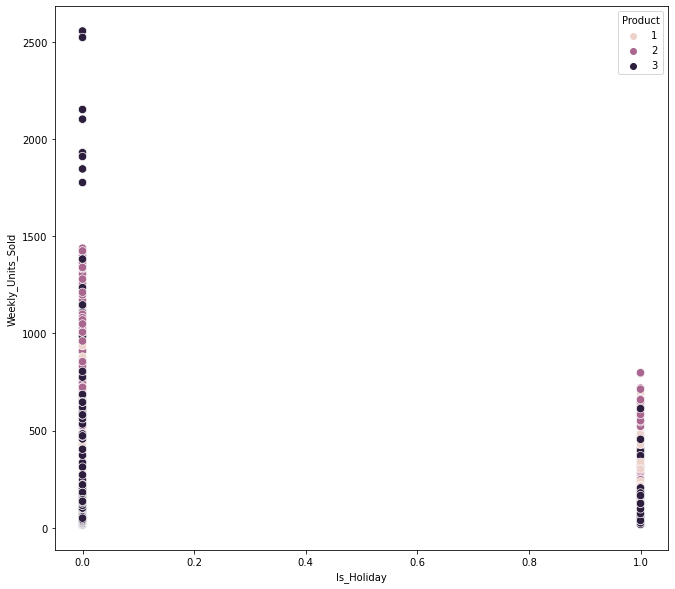

In [109]:
plt.figure(figsize = (11,10))
sns.scatterplot(data= data, x= 'Is_Holiday', y= 'Weekly_Units_Sold', hue= 'Product',s=70);


In [110]:
#Product1 = data.loc[data['Product'] == 1]
#Product2 = data.loc[data['Product'] == 2]
#Product3 = data.loc[data['Product'] == 3]
#Product1
#plt.scatter("Price", "Weekly_Units_Sold");
#plt.scatter('Price','Weekly_Sales_Price');
#sns.scatterplot(data= Product3, x= 'Is_Holiday', y= 'Weekly_Sales_Price', hue= 'Product');

It seems like there a good promotion product 3 but still not affecting its selling performance in holidays compared to product 2.

In [111]:
data['Product'].resample('W').mean()

Date
2010-02-07    2
2010-02-14    2
2010-02-21    2
2010-02-28    2
2010-03-07    2
             ..
2012-09-30    2
2012-10-07    2
2012-10-14    2
2012-10-21    2
2012-10-28    2
Freq: W-SUN, Name: Product, Length: 143, dtype: int64

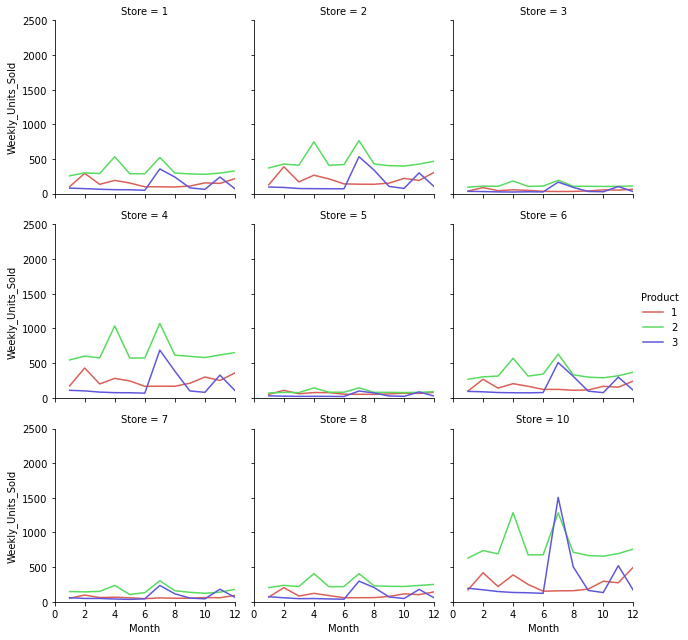

In [112]:
g = sns.FacetGrid(data, col="Store", hue='Product',ylim= (0,2500), xlim=(0,12) ,palette="hls", col_wrap=3)
g.map(sns.lineplot, "Month", "Weekly_Units_Sold", ci= None)
g.add_legend();

For most stores, product 2 is the best seller for most of time. interesting! 
Product 1 sells a little more in February than the other months, Product 2 sells the most around April and July, and Product 3 sells the most around July to September.

Why Store 10 is selling the most regarding product product 3, is it kind of promotion?

In [113]:
def f(row):
    if row['Base Price'] == row['Price']:
        val = 0
    elif row['Base Price'] > row['Price']:
        val = 1
    else:
        val = -1
    return val
data['promotion'] = data.apply(f, axis=1)

In [114]:
data1 = data.groupby(['Store','promotion','Product'])['Price', 'Weekly_Units_Sold','Weekly_Sales_Price'].mean()
data1

Price  Weekly_Units_Sold  Weekly_Sales_Price
Store promotion Product                                                  
1     0         1        10.653866         134.226891         1423.195546
                2         6.294348         291.278261         1822.748087
                3        20.700744          84.107438         1734.563884
      1         1         8.523333         223.208333         1896.901250
                2         4.201429         527.821429         2205.554286
                3        10.409091         314.363636         3250.863636
2     0         1        10.653866         184.294118         1952.871345
                2         6.294348         416.443478         2605.070348
                3        20.700744         110.495868         2278.002479
      1         1         8.523333         300.750000         2552.692500
                2         4.201429         756.857143         3161.722857
                3        10.409091         448.318182         4635.772727
3     0         1        10.653866          43.873950          467.989832
                2         6.294348         106.147826          667.677652
                3        20.700744          34.710744          715.719008
      1         1         8.523333          67.750000          578.755833
                2         4.201429         188.428571          792.305000
                3        10.409091         143.590909         1485.272727
4     0         1        10.653866         224.159664         2380.388655
                2         6.294348         592.182609         3712.982522
                3        20.700744         116.917355         2410.764711
      1         1         8.523333         335.708333         2853.742917
                2         4.201429        1053.785714         4416.630714
                3        10.409091         556.000000         5751.954545
5     0         1        10.653866          58.848739          626.167815
                2         6.294348          77.547826          485.694087
                3        20.700744          26.528926          547.255372
      1         1         8.523333          90.166667          767.865000
                2         4.201429         142.250000          594.446786
                3        10.409091          91.909091          954.000000
6     0         1        10.653866         145.411765         1540.613109
                2         6.294348         314.113043         1967.441478
                3        20.700744         106.157025         2189.533471
      1         1         8.523333         215.416667         1827.312500
                2         4.201429         599.142857         2505.025000
                3        10.409091         430.909091         4459.000000
7     0         1        10.653866          59.025210          627.308908
                2         6.294348         140.800000          882.748522
                3        20.700744          54.801653         1130.642066
      1         1         8.523333          77.500000          658.025000
                2         4.201429         270.107143         1132.901071
                3        10.409091         216.227273         2238.954545
8     0         1        10.653866          87.983193          933.111765
                2         6.294348         226.060870         1414.608957
                3        20.700744          68.388430         1411.497934
      1         1         8.523333         147.041667         1250.429583
                2         4.201429         407.178571         1700.623571
                3        10.409091         254.590909         2632.227273
10    0         1        10.653866         246.915966         2614.875378
                2         6.294348         691.921739         4323.072087
                3        20.700744         187.628099         3874.454298
      1         1         8.523333         335.000000         2842.683333
                2         4.20142

In [115]:
#g = sns.FacetGrid(data, col="Store", hue="promotion", palette = 'hls')
#g = (g.map(sns.barplot, "Product", "Weekly_Units_Sold").add_legend())

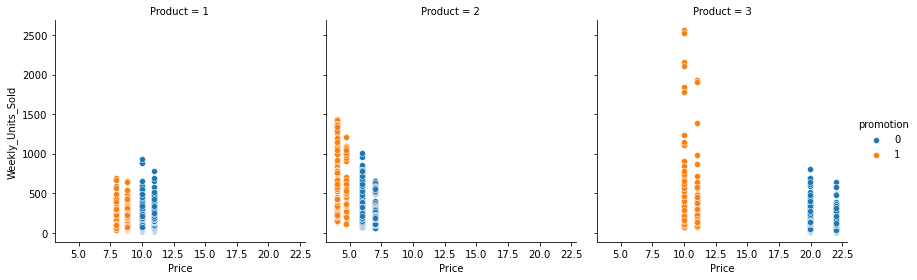

In [116]:
g = sns.FacetGrid(data, hue="promotion", col="Product", height=4)
g.map(sns.scatterplot, "Price", "Weekly_Units_Sold")
g.add_legend();

Product 3 has a half price discount and selling the most meanwhile.

## Sales Prediction

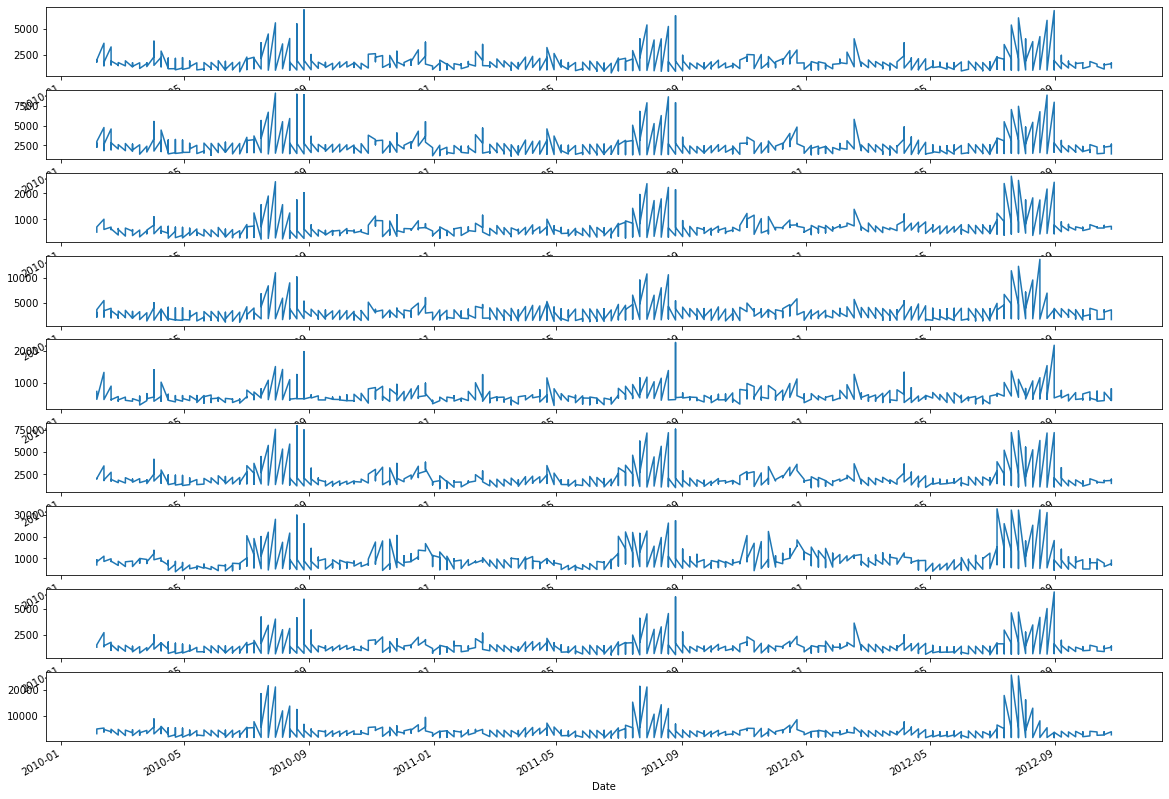

In [117]:
# store types
sales_1 = data[data.Store == 1]['Weekly_Sales_Price']
sales_2 = data[data.Store == 2]['Weekly_Sales_Price']
sales_3 = data[data.Store == 3]['Weekly_Sales_Price']
sales_4 = data[data.Store == 4]['Weekly_Sales_Price']
sales_5 = data[data.Store == 5]['Weekly_Sales_Price']
sales_6 = data[data.Store == 6]['Weekly_Sales_Price']
sales_7 = data[data.Store == 7]['Weekly_Sales_Price']
sales_8 = data[data.Store == 8]['Weekly_Sales_Price']
sales_10 = data[data.Store == 10]['Weekly_Sales_Price']

fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9) = plt.subplots(9, figsize = (20, 15))

# store types
sales_1.plot( ax = ax1)
sales_2.plot( ax = ax2)
sales_3.plot( ax = ax3)
sales_4.plot( ax = ax4)
sales_5.plot( ax = ax5)
sales_6.plot( ax = ax6)
sales_7.plot( ax = ax7)
sales_8.plot( ax = ax8)
sales_10.plot( ax = ax9);

In [136]:
data_1 = data.copy()

Let's see prediction impact on product 2, it shows some seasonality in April and July.

In [119]:
store_10_Pro_2 = data_1[(data_1.Store == 10) & (data_1.Product == 2)].loc[:,['Base Price', 'Price', 'Weekly_Units_Sold', 'Weekly_Sales_Price']]
store_10_Pro_2.describe()


,Base Price,Price,Weekly_Units_Sold,Weekly_Sales_Price
count,143.000000,143.000000,143.000000,143.000000
mean,6.290699,5.884545,807.916084,4525.686503
std,0.460174,0.940282,255.924381,538.215432
min,5.990000,4.010000,521.000000,3522.120000
25%,5.990000,5.990000,650.500000,4173.030000
50%,5.990000,5.990000,727.000000,4375.740000
75%,6.990000,5.990000,800.500000,4783.015000
max,6.990000,6.990000,1439.000000,6031.930000


In [120]:
store_10_Pro_2.reset_index(level=0, inplace=True) #as index here is the date
fig = px.line(store_10_Pro_2, x='Date', y='Weekly_Sales_Price')
fig.update_layout(title_text='Time Series of weekly sales')
fig.show()

tracking product 2 is qiute hard, as it desn't show 

In [121]:
store_10_Pro_2 = store_10_Pro_2.rename(columns={'Date': 'ds', 'Weekly_Sales_Price': 'y'})

In [122]:
model = Prophet()
# fit the model
model.fit(store_10_Pro_2)
# define the period for weekly prediction
future_dates = model.make_future_dataframe(periods = 113, freq='W') #till the end of 2014
future_dates.tail() 

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
251,2014-11-23
252,2014-11-30
253,2014-12-07
254,2014-12-14
255,2014-12-21


In [123]:
forecast = model.predict(future_dates)

# preditions for last week
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
249,2014-11-09,3434.078127,3112.519660,3782.241661
250,2014-11-16,3204.177842,2863.726152,3556.445210
251,2014-11-23,3009.613734,2691.112453,3328.765379
252,2014-11-30,3118.672888,2749.367758,3441.947486
253,2014-12-07,3542.258906,3205.957683,3873.967244
254,2014-12-14,3979.538122,3638.733214,4330.176444
255,2014-12-21,4082.055667,3746.955142,4437.047064


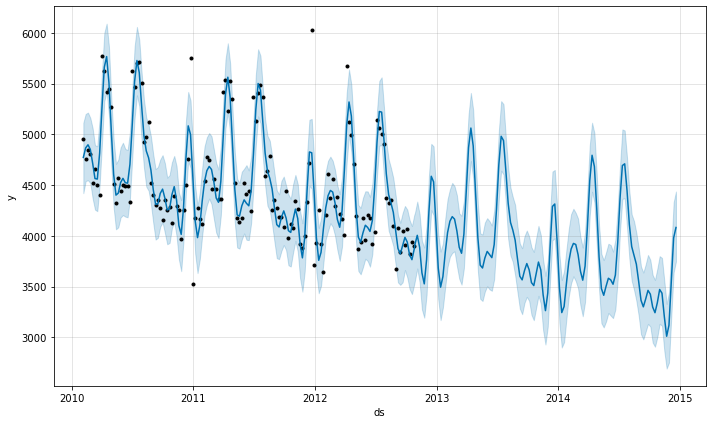

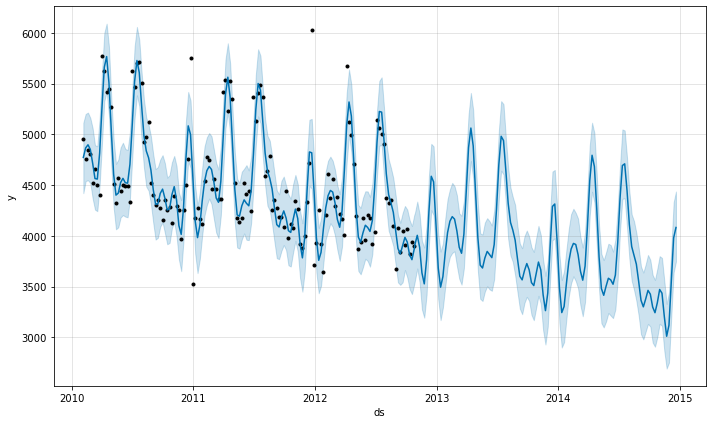

In [124]:
model.plot(forecast)


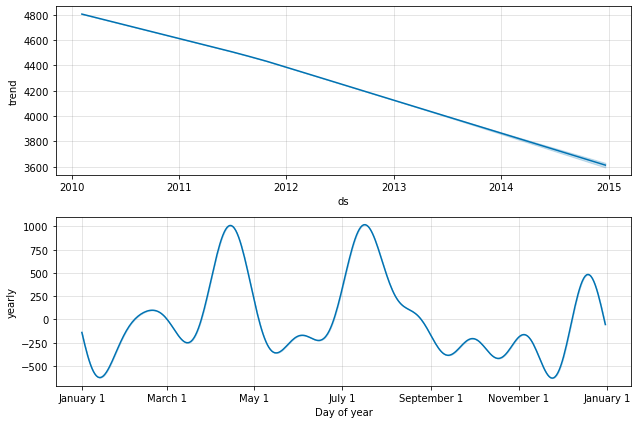

In [125]:
model.plot_components(forecast);

In [126]:
metric_df = forecast.set_index('ds')[['yhat']].join(store_10_Pro_2.set_index('ds').y).reset_index()
metric_df.dropna(inplace=True)
error = mean_squared_error(metric_df.y, metric_df.yhat)
print('The RMSE is {}'. format(sqrt(error)))

The RMSE is 255.73586707258002


While weekly sales price is a range between 3500 and 6000 as weekly sales price, here we got RMSE is 255.73 which is good.

In [127]:
store_10_Pro_3 = data[(data.Store == 10) & (data.Product == 3)].loc[:,['Base Price', 'Price', 'Weekly_Units_Sold', 'Weekly_Sales_Price']]
store_10_Pro_3.describe()


,Base Price,Price,Weekly_Units_Sold,Weekly_Sales_Price
count,143.000000,143.000000,143.000000,143.000000
mean,20.717273,19.117413,335.447552,5101.426364
std,0.965473,3.834518,474.482857,4848.319409
min,19.990000,10.000000,101.000000,2220.990000
25%,19.990000,19.990000,133.000000,2722.700000
50%,19.990000,19.990000,155.000000,3144.570000
75%,21.990000,21.990000,222.000000,4482.860000
max,21.990000,21.990000,2557.000000,25570.000000


In [128]:
store_10_Pro_3.head()

,Base Price,Price,Weekly_Units_Sold,Weekly_Sales_Price
Date,,,,
2010-02-05,19.99,19.99,201,4017.99
2010-02-12,19.99,19.99,191,3818.09
2010-02-19,19.99,19.99,177,3538.23
2010-02-26,19.99,19.99,189,3778.11
2010-03-05,19.99,19.99,178,3558.22


In [129]:
store_10_Pro_3.reset_index(level=0, inplace=True) #as index here is the date
fig = px.line(store_10_Pro_3, x='Date', y='Weekly_Sales_Price')
fig.update_layout(title_text='Time Series of weekly sales')
fig.show()

Weekly sales shows a very recognizable seasonal trend for product 3 in store 10 as shown before, July is the hot season for it.

In [130]:
store_10_Pro_3 = store_10_Pro_3.rename(columns={'Date': 'ds', 'Weekly_Sales_Price': 'y'})
model = Prophet()
# fit the model
model.fit(store_10_Pro_3)
# define the period for weekly prediction
future_dates = model.make_future_dataframe(periods = 113, freq='W') #till the end of 2014
future_dates.tail()

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
251,2014-11-23
252,2014-11-30
253,2014-12-07
254,2014-12-14
255,2014-12-21


In [131]:
forecast_1 = model.predict(future_dates)

# preditions for last week
forecast_1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
249,2014-11-09,5637.360887,4158.761712,7113.227961
250,2014-11-16,5704.811838,4163.937594,7241.780690
251,2014-11-23,4653.767471,3092.578175,6219.974156
252,2014-11-30,3650.026406,2210.958151,5186.803250
253,2014-12-07,3433.615197,1946.801782,4898.953606
254,2014-12-14,3674.313888,2211.165320,5151.036707
255,2014-12-21,3682.025436,2232.617876,5254.972249


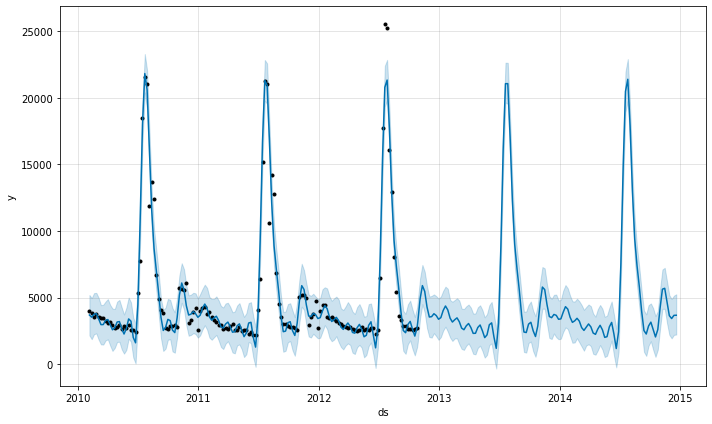

In [132]:
model.plot(forecast_1);

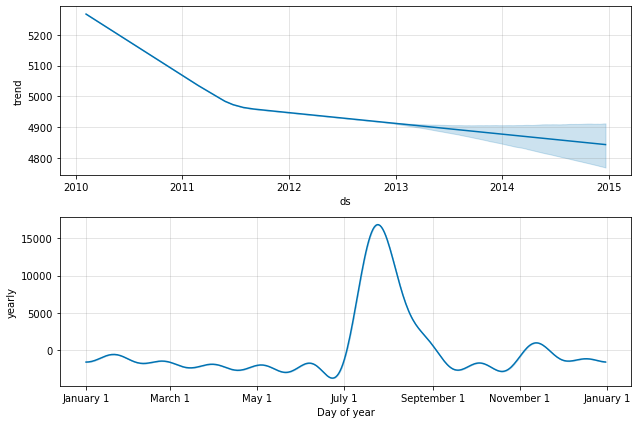

In [133]:
model.plot_components(forecast_1);

In [134]:
metric_df = forecast_1.set_index('ds')[['yhat']].join(store_10_Pro_3.set_index('ds').y).reset_index()
metric_df.dropna(inplace=True)
error = mean_squared_error(metric_df.y, metric_df.yhat)
print('The RMSE is {}'. format(sqrt(error)))
#print('RMSE: %f' % error)

The RMSE is 1190.0888340961621


In [135]:
test_result=adfuller(store_10_Pro_3['Weekly_Sales_Price'])

KeyError: 'Weekly_Sales_Price'

In [ ]:
#Ho: It is non stationary
#H1: It is stationary
def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")
    

In [ ]:
adfuller_test(store_10_Pro_3['Weekly_Sales_Price'])

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [ ]:
#model=ARIMA(store_10_Pro_3['Weekly_Sales_Price'],order=(1,1,1))
#model_fit=model.fit()

In [ ]:
#model_fit.summary()

In [ ]:
store_10_Pro_3['forecast']=model_fit.predict(start=start,end=end,dynamic=True)
store_10_Pro_3[['Weekly_Sales_Price','forecast']].plot(figsize=(12,8))

In [ ]:
import statsmodels.api as sm

In [ ]:
model=sm.tsa.statespace.SARIMAX(store_10_Pro_3['Weekly_Sales_Price'],order=(3, 0, 1),seasonal_order=(1,1,4,30))
results=model.fit()

In [ ]:
store_10_Pro_3['forecast']=results.predict(start=70,end=90,dynamic=True)
store_10_Pro_3[['Weekly_Sales_Price','forecast']].plot(figsize=(12,8))

In [ ]:
store_10_Pro3 = data[(data.Store == 10) & (data.Product == 3)].loc[:,['Base Price', 'Price', 'Weekly_Units_Sold', 'Weekly_Sales_Price']]
store_10_Pro3.describe()

In [ ]:
store_10_Pro3.head()

In [ ]:
train = store_10_Pro3[:114]
test = store_10_Pro3[-29:]

In [ ]:
len(store_10_Pro3)

In [ ]:
train.tail()

In [ ]:
test.head()

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(train)
plt.plot(test)
plt.xlabel('Date')
plt.ylabel('Weekly_Sales_Price')

In [ ]:
train = train['Weekly_Sales_Price']


In [ ]:
test = test['Weekly_Sales_Price']

In [ ]:

arima_model =  auto_arima(train,start_p=0, d=1, start_q=0, 
                          max_p=5, max_d=5, max_q=5, start_P=0, 
                          D=1, start_Q=0, max_P=5, max_D=5,
                          max_Q=5, m=12, seasonal=True, 
                          error_action='warn',trace = True,
                          supress_warnings=True,stepwise = True,
                          random_state=20,n_fits = 50 )

In [ ]:
prediction = pd.DataFrame(arima_model.predict(n_periods = 29),index=test.index)
prediction.columns = ['predicted_sales']
abs(prediction)

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(train,label="Training")
plt.plot(test,label="Test")
plt.plot(prediction,label="Predicted")
plt.xticks(range(0,len(dd.index)), dd.index)
#plt.legend(loc = 'l')
plt.show()

In [ ]:
from sklearn.metrics import r2_score
test['predicted_sales'] = prediction
r2_score(test['Weekly_Sales_Price'], test['predicted_sales'])